<a href="https://colab.research.google.com/github/Zardian18/DCGAN-lego-bricks/blob/master/DC_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py

--2024-01-05 00:01:51--  https://raw.githubusercontent.com/Zardian18/helper-functions-colab/master/helper.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 17171 (17K) [text/plain]
Saving to: ‘helper.py’

helper.py           100%[===================>]  16.77K  --.-KB/s    in 0s      

2024-01-05 00:01:52 (123 MB/s) - ‘helper.py’ saved [17171/17171]



In [2]:
!pip install kaggle

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Dataset

In [4]:
! mkdir ~/.kaggle

In [5]:
!cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/kaggle.json

In [6]:
!chmod 600 ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download -d joosthazelzet/lego-brick-images

100% 0.99G/1.00G [00:41<00:00, 25.6MB/s]
100% 1.00G/1.00G [00:41<00:00, 25.7MB/s]


In [ ]:
! unzip lego-brick-images.zip

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, utils, metrics, losses, optimizers
from helper import sample_batch, display, get_vector_from_label, add_vector_to_images, morph_faces
import pandas as pd
import numpy as np
import tensorflow.keras.backend as K

In [10]:
train_data = utils.image_dataset_from_directory(
    "/content/dataset",
    labels= None,
    color_mode= "grayscale",
    image_size=(64,64),
    batch_size=128,
    shuffle = True,
    seed=42,
    interpolation= "bilinear"
)

Found 40000 files belonging to 1 classes.


In [11]:
train_data

<_PrefetchDataset element_spec=TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None)>

In [12]:
def preprocess(imgs):
  imgs = (tf.cast(imgs, "float32")-127.5)/127.5
  return imgs

In [13]:
train = train_data.map(lambda x: preprocess(x))

In [14]:
train

<_MapDataset element_spec=TensorSpec(shape=(None, 64, 64, 1), dtype=tf.float32, name=None)>

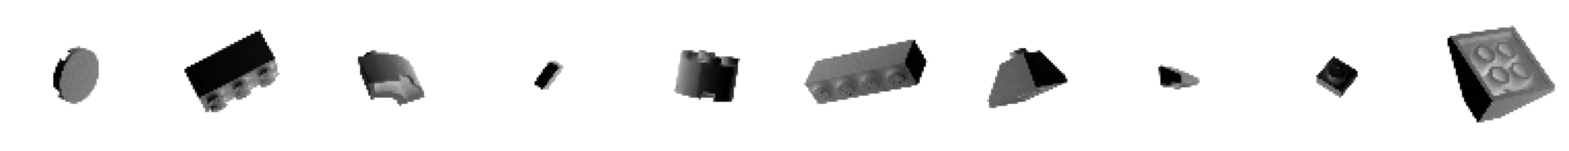

In [15]:
train_sample = sample_batch(train)
display(train_sample) # lego bricks

## Discriminator

In [16]:
from re import X
discriminator_input = layers.Input(shape=(64,64,1))
x= layers.Conv2D(64, 4, strides=2, padding= "same", use_bias = False)(discriminator_input)
x = layers.LeakyReLU(0.3)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(128, 4, strides =2, padding="same", use_bias= False)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(256, 4, strides =2, padding="same", use_bias= False)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(512, 4, strides =2, padding="same", use_bias= False)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)
x = layers.Dropout(0.3)(x)

x = layers.Conv2D(1, 4, strides=1, padding ="valid", use_bias= False, activation="sigmoid")(x)

discriminator_output = layers.Flatten()(x)

discriminator = tf.keras.Model(discriminator_input, discriminator_output)

In [17]:
discriminator.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 64)        1024      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32, 32, 64)        0         
                                                                 
 dropout (Dropout)           (None, 32, 32, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       131072    
                                                                 
 batch_normalization (Batch  (None, 16, 16, 128)       512       
 Normalization)                                                  
                                                             

## Generator

In [18]:
generator_input = layers.Input(shape=(100,))
x= layers.Reshape((1,1, 100))(generator_input)

x = layers.Conv2DTranspose(512, 4, strides =2, padding ="valid", use_bias = False)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(256, 4, strides =2, padding ="same", use_bias = False)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(128, 4, strides =2, padding ="same", use_bias = False)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)

x = layers.Conv2DTranspose(64, 4, strides =2, padding ="same", use_bias = False)(x)
x = layers.BatchNormalization(momentum = 0.9)(x)
x = layers.LeakyReLU(0.2)(x)

generator_output = layers.Conv2DTranspose(1, 4, strides= 2, padding="same", use_bias= False, activation= "tanh")(x)

generator = tf.keras.Model(generator_input, generator_output)

In [19]:
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 reshape (Reshape)           (None, 1, 1, 100)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 4, 4, 512)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_3 (Bat  (None, 4, 4, 512)         2048      
 chNormalization)                                                
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 4, 4, 512)         0         
                                                                 
 conv2d_transpose_1 (Conv2D  (None, 8, 8, 256)         2097

In [20]:
class DCGAN(models.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super(DCGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim

    def compile(self, d_optimizer, g_optimizer):
        super(DCGAN, self).compile()
        self.loss_fn = losses.BinaryCrossentropy()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_metric = metrics.Mean(name="d_loss")
        self.d_real_acc_metric = metrics.BinaryAccuracy(name="d_real_acc")
        self.d_fake_acc_metric = metrics.BinaryAccuracy(name="d_fake_acc")
        self.d_acc_metric = metrics.BinaryAccuracy(name="d_acc")
        self.g_loss_metric = metrics.Mean(name="g_loss")
        self.g_acc_metric = metrics.BinaryAccuracy(name="g_acc")

    @property
    def metrics(self):
        return [
            self.d_loss_metric,
            self.d_real_acc_metric,
            self.d_fake_acc_metric,
            self.d_acc_metric,
            self.g_loss_metric,
            self.g_acc_metric,
        ]

    def train_step(self, real_images):
        # Sample random points in the latent space
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )

        # Train the discriminator on fake images
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.generator(
                random_latent_vectors, training=True
            )
            real_predictions = self.discriminator(real_images, training=True)
            fake_predictions = self.discriminator(
                generated_images, training=True
            )

            real_labels = tf.ones_like(real_predictions)
            real_noisy_labels = real_labels + 0.1 * tf.random.uniform(
                tf.shape(real_predictions)
            )
            fake_labels = tf.zeros_like(fake_predictions)
            fake_noisy_labels = fake_labels - 0.1 * tf.random.uniform(
                tf.shape(fake_predictions)
            )

            d_real_loss = self.loss_fn(real_noisy_labels, real_predictions)
            d_fake_loss = self.loss_fn(fake_noisy_labels, fake_predictions)
            d_loss = (d_real_loss + d_fake_loss) / 2.0

            g_loss = self.loss_fn(real_labels, fake_predictions)

        gradients_of_discriminator = disc_tape.gradient(
            d_loss, self.discriminator.trainable_variables
        )
        gradients_of_generator = gen_tape.gradient(
            g_loss, self.generator.trainable_variables
        )

        self.d_optimizer.apply_gradients(
            zip(gradients_of_discriminator, discriminator.trainable_variables)
        )
        self.g_optimizer.apply_gradients(
            zip(gradients_of_generator, generator.trainable_variables)
        )

        self.d_loss_metric.update_state(d_loss)
        self.d_real_acc_metric.update_state(real_labels, real_predictions)
        self.d_fake_acc_metric.update_state(fake_labels, fake_predictions)
        self.d_acc_metric.update_state(
            [real_labels, fake_labels], [real_predictions, fake_predictions]
        )
        self.g_loss_metric.update_state(g_loss)
        self.g_acc_metric.update_state(real_labels, fake_predictions)

        return {m.name: m.result() for m in self.metrics}

In [21]:
dcgan= DCGAN(discriminator= discriminator, generator = generator, latent_dim =100)

In [22]:
dcgan.compile(
    d_optimizer = optimizers.Adam(learning_rate= 0.0002, beta_1 = 0.5, beta_2 = 0.99),
    g_optimizer = optimizers.Adam(learning_rate = 0.0002, beta_1 = 0.5, beta_2 = 0.99),
)

In [23]:
model_checkpoint_callback = callbacks.ModelCheckpoint(
    filepath="./checkpoint/checkpoint.ckpt",
    save_weights_only=True,
    save_freq="epoch",
    verbose=0,
)

tensorboard_callback = callbacks.TensorBoard(log_dir="./logs")


class ImageGenerator(callbacks.Callback):
    def __init__(self, num_img, latent_dim):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(
            shape=(self.num_img, self.latent_dim)
        )
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = generated_images * 127.5 + 127.5
        generated_images = generated_images.numpy()
        display(
            generated_images,
            save_to="./output/generated_img_%03d.png" % (epoch),
        )

In [24]:
! mkdir output/

Epoch 1/50
  6/313 [..............................] - ETA: 46s - d_loss: 0.1799 - d_real_acc: 0.8880 - d_fake_acc: 0.8281 - d_acc: 0.8581 - g_loss: 1.9857 - g_acc: 0.1719

313/313 [==============================] - ETA: 0s - d_loss: 0.2571 - d_real_acc: 0.8263 - d_fake_acc: 0.8324 - d_acc: 0.8293 - g_loss: 4.7798 - g_acc: 0.1676
Saved to ./output/generated_img_000.png


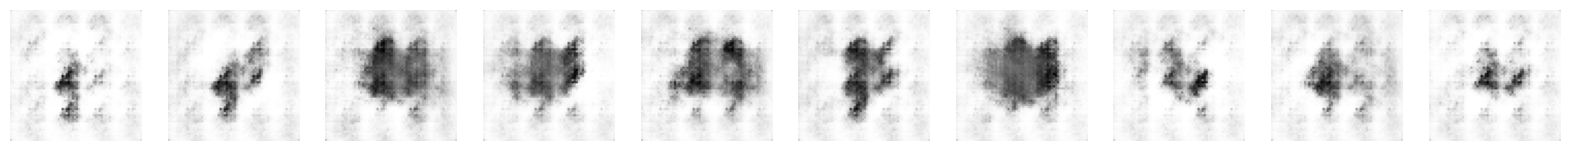

313/313 [==============================] - 90s 237ms/step - d_loss: 0.2571 - d_real_acc: 0.8263 - d_fake_acc: 0.8324 - d_acc: 0.8293 - g_loss: 4.7798 - g_acc: 0.1676
Epoch 2/50
313/313 [==============================] - ETA: 0s - d_loss: 0.1455 - d_real_acc: 0.8755 - d_fake_acc: 0.8809 - d_acc: 0.8782 - g_loss: 3.9240 - g_acc: 0.1191
Saved to ./output/generated_img_001.png


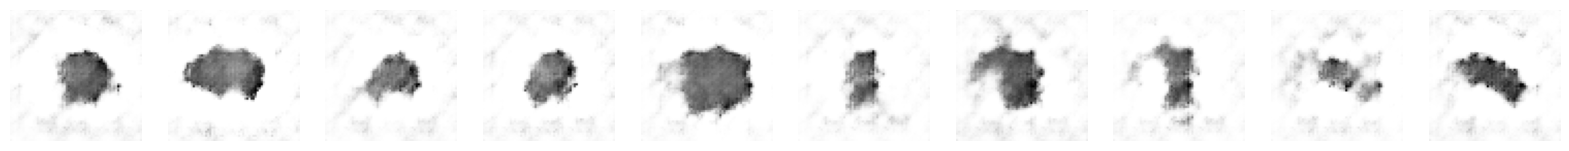

313/313 [==============================] - 77s 238ms/step - d_loss: 0.1455 - d_real_acc: 0.8755 - d_fake_acc: 0.8809 - d_acc: 0.8782 - g_loss: 3.9240 - g_acc: 0.1191
Epoch 3/50
313/313 [==============================] - ETA: 0s - d_loss: 0.1193 - d_real_acc: 0.8849 - d_fake_acc: 0.8820 - d_acc: 0.8835 - g_loss: 4.1943 - g_acc: 0.1179
Saved to ./output/generated_img_002.png


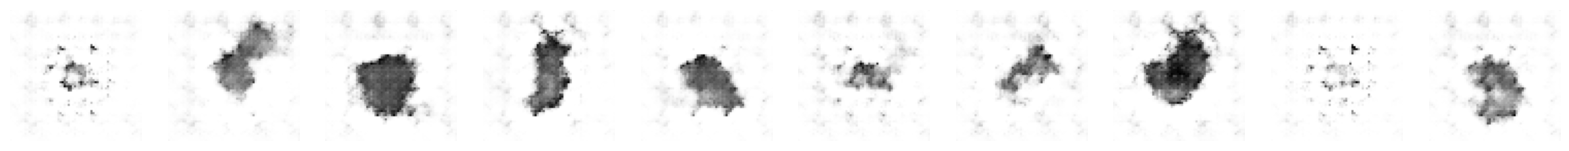

313/313 [==============================] - 77s 241ms/step - d_loss: 0.1193 - d_real_acc: 0.8849 - d_fake_acc: 0.8820 - d_acc: 0.8835 - g_loss: 4.1943 - g_acc: 0.1179
Epoch 4/50
313/313 [==============================] - ETA: 0s - d_loss: 0.1752 - d_real_acc: 0.8609 - d_fake_acc: 0.8624 - d_acc: 0.8616 - g_loss: 3.8913 - g_acc: 0.1376
Saved to ./output/generated_img_003.png


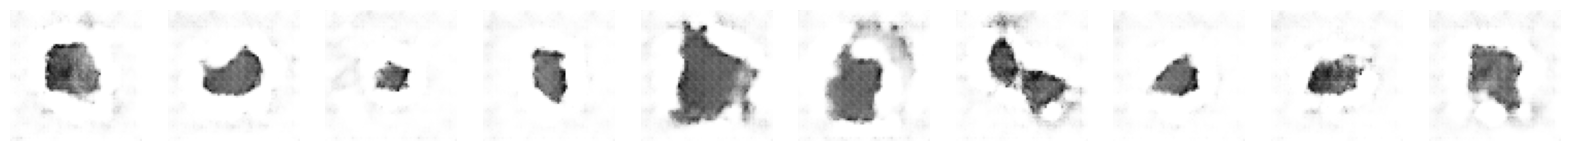

313/313 [==============================] - 77s 242ms/step - d_loss: 0.1752 - d_real_acc: 0.8609 - d_fake_acc: 0.8624 - d_acc: 0.8616 - g_loss: 3.8913 - g_acc: 0.1376
Epoch 5/50
313/313 [==============================] - ETA: 0s - d_loss: 0.1583 - d_real_acc: 0.8748 - d_fake_acc: 0.8750 - d_acc: 0.8749 - g_loss: 3.7863 - g_acc: 0.1250
Saved to ./output/generated_img_004.png


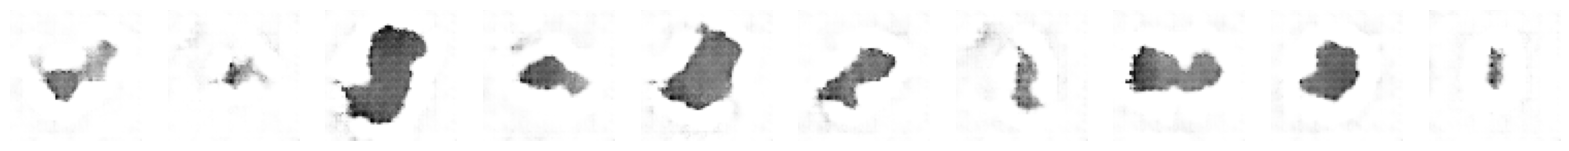

313/313 [==============================] - 77s 242ms/step - d_loss: 0.1583 - d_real_acc: 0.8748 - d_fake_acc: 0.8750 - d_acc: 0.8749 - g_loss: 3.7863 - g_acc: 0.1250
Epoch 6/50
313/313 [==============================] - ETA: 0s - d_loss: 0.1077 - d_real_acc: 0.8828 - d_fake_acc: 0.8866 - d_acc: 0.8847 - g_loss: 3.9258 - g_acc: 0.1134
Saved to ./output/generated_img_005.png


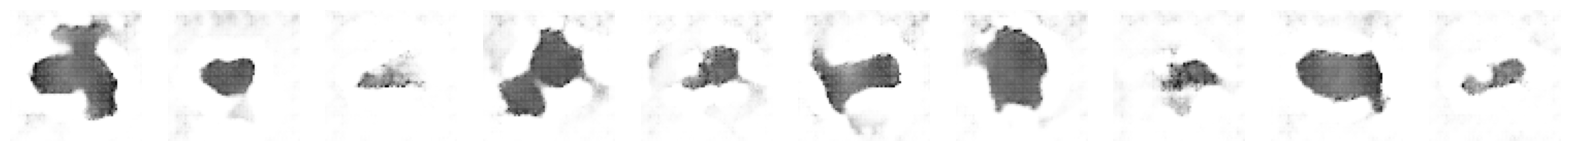

313/313 [==============================] - 77s 243ms/step - d_loss: 0.1077 - d_real_acc: 0.8828 - d_fake_acc: 0.8866 - d_acc: 0.8847 - g_loss: 3.9258 - g_acc: 0.1134
Epoch 7/50
313/313 [==============================] - ETA: 0s - d_loss: 0.1372 - d_real_acc: 0.8814 - d_fake_acc: 0.8837 - d_acc: 0.8826 - g_loss: 4.0109 - g_acc: 0.1164
Saved to ./output/generated_img_006.png


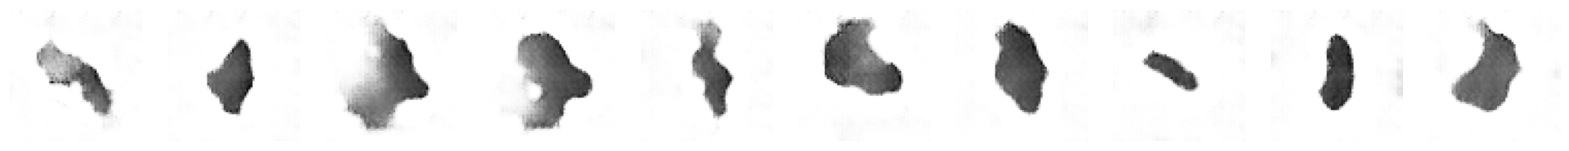

313/313 [==============================] - 77s 241ms/step - d_loss: 0.1372 - d_real_acc: 0.8814 - d_fake_acc: 0.8837 - d_acc: 0.8826 - g_loss: 4.0109 - g_acc: 0.1164
Epoch 8/50
313/313 [==============================] - ETA: 0s - d_loss: 0.0988 - d_real_acc: 0.8915 - d_fake_acc: 0.8959 - d_acc: 0.8937 - g_loss: 4.0187 - g_acc: 0.1041
Saved to ./output/generated_img_007.png


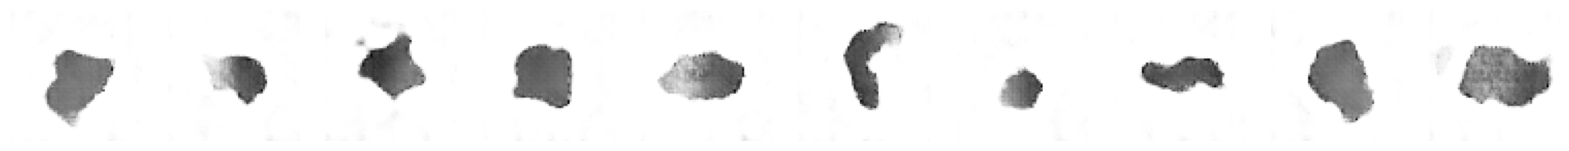

313/313 [==============================] - 80s 253ms/step - d_loss: 0.0988 - d_real_acc: 0.8915 - d_fake_acc: 0.8959 - d_acc: 0.8937 - g_loss: 4.0187 - g_acc: 0.1041
Epoch 9/50
313/313 [==============================] - ETA: 0s - d_loss: 0.0625 - d_real_acc: 0.9014 - d_fake_acc: 0.9014 - d_acc: 0.9014 - g_loss: 4.4439 - g_acc: 0.0986
Saved to ./output/generated_img_008.png


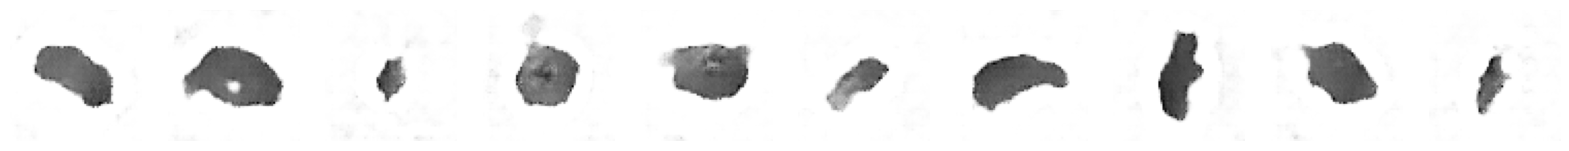

313/313 [==============================] - 79s 243ms/step - d_loss: 0.0625 - d_real_acc: 0.9014 - d_fake_acc: 0.9014 - d_acc: 0.9014 - g_loss: 4.4439 - g_acc: 0.0986
Epoch 10/50
313/313 [==============================] - ETA: 0s - d_loss: 0.1159 - d_real_acc: 0.8903 - d_fake_acc: 0.8906 - d_acc: 0.8904 - g_loss: 4.2768 - g_acc: 0.1094
Saved to ./output/generated_img_009.png


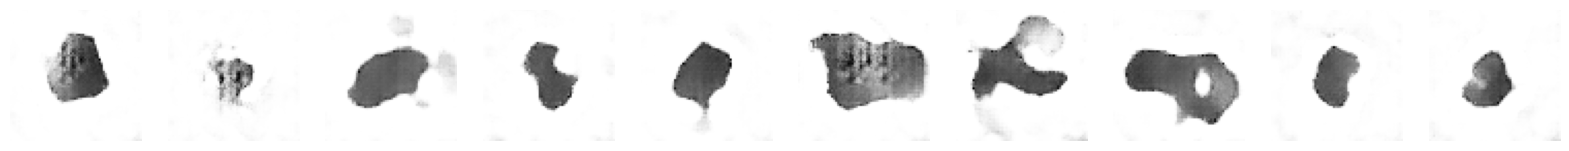

313/313 [==============================] - 79s 243ms/step - d_loss: 0.1159 - d_real_acc: 0.8903 - d_fake_acc: 0.8906 - d_acc: 0.8904 - g_loss: 4.2768 - g_acc: 0.1094
Epoch 11/50
313/313 [==============================] - ETA: 0s - d_loss: 0.0404 - d_real_acc: 0.9126 - d_fake_acc: 0.9141 - d_acc: 0.9134 - g_loss: 4.6977 - g_acc: 0.0859
Saved to ./output/generated_img_010.png


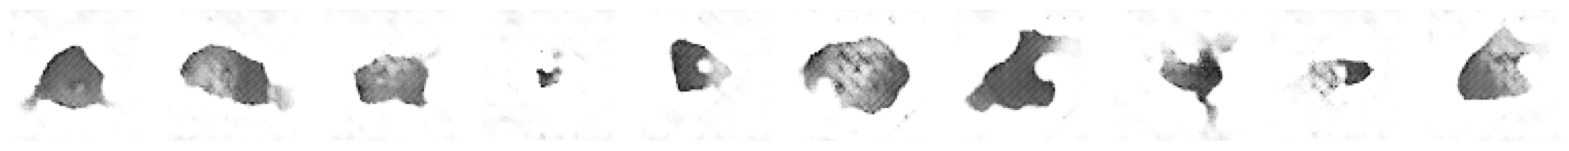

313/313 [==============================] - 78s 244ms/step - d_loss: 0.0404 - d_real_acc: 0.9126 - d_fake_acc: 0.9141 - d_acc: 0.9134 - g_loss: 4.6977 - g_acc: 0.0859
Epoch 12/50
313/313 [==============================] - ETA: 0s - d_loss: 0.0165 - d_real_acc: 0.9129 - d_fake_acc: 0.9181 - d_acc: 0.9155 - g_loss: 4.8170 - g_acc: 0.0819
Saved to ./output/generated_img_011.png


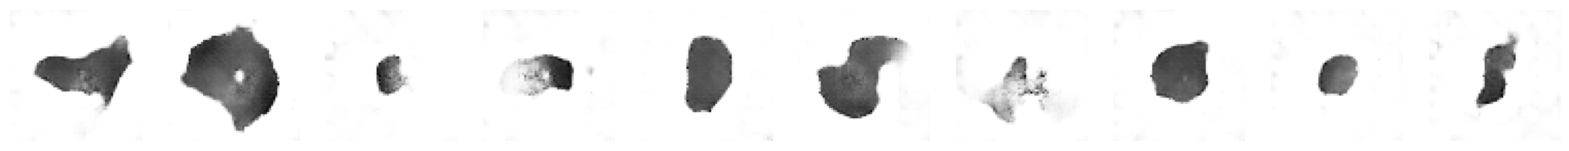

313/313 [==============================] - 79s 247ms/step - d_loss: 0.0165 - d_real_acc: 0.9129 - d_fake_acc: 0.9181 - d_acc: 0.9155 - g_loss: 4.8170 - g_acc: 0.0819
Epoch 13/50
313/313 [==============================] - ETA: 0s - d_loss: 0.0042 - d_real_acc: 0.9140 - d_fake_acc: 0.9147 - d_acc: 0.9144 - g_loss: 5.2507 - g_acc: 0.0853
Saved to ./output/generated_img_012.png


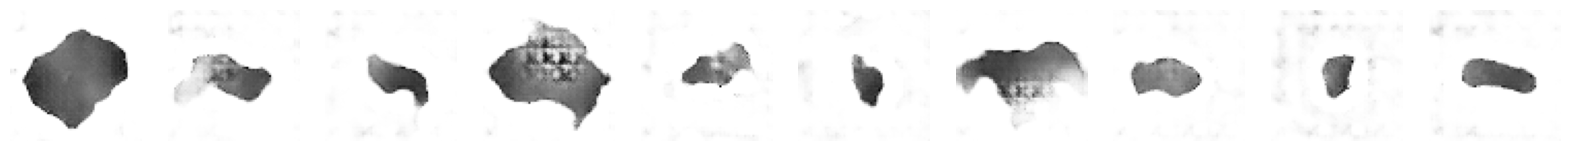

313/313 [==============================] - 80s 247ms/step - d_loss: 0.0042 - d_real_acc: 0.9140 - d_fake_acc: 0.9147 - d_acc: 0.9144 - g_loss: 5.2507 - g_acc: 0.0853
Epoch 14/50
313/313 [==============================] - ETA: 0s - d_loss: -0.0075 - d_real_acc: 0.9169 - d_fake_acc: 0.9168 - d_acc: 0.9169 - g_loss: 5.4444 - g_acc: 0.0832
Saved to ./output/generated_img_013.png


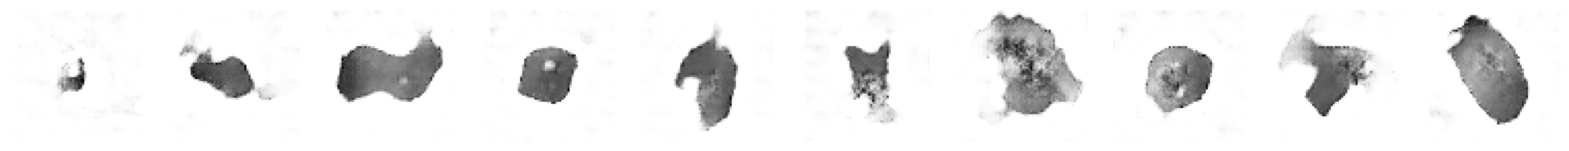

313/313 [==============================] - 79s 248ms/step - d_loss: -0.0075 - d_real_acc: 0.9169 - d_fake_acc: 0.9168 - d_acc: 0.9169 - g_loss: 5.4444 - g_acc: 0.0832
Epoch 15/50
313/313 [==============================] - ETA: 0s - d_loss: -0.0095 - d_real_acc: 0.9172 - d_fake_acc: 0.9190 - d_acc: 0.9181 - g_loss: 5.4160 - g_acc: 0.0810
Saved to ./output/generated_img_014.png


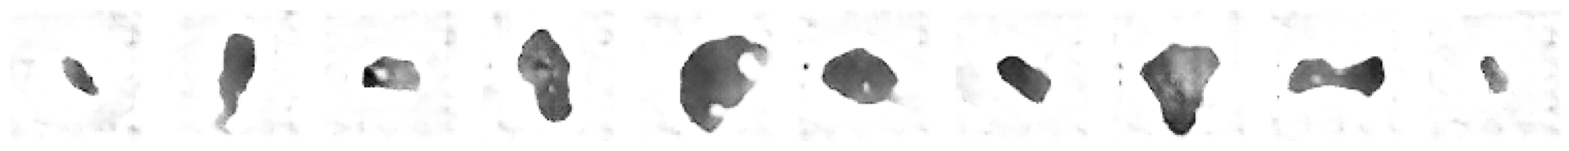

313/313 [==============================] - 79s 248ms/step - d_loss: -0.0095 - d_real_acc: 0.9172 - d_fake_acc: 0.9190 - d_acc: 0.9181 - g_loss: 5.4160 - g_acc: 0.0810
Epoch 16/50
313/313 [==============================] - ETA: 0s - d_loss: 0.0052 - d_real_acc: 0.9158 - d_fake_acc: 0.9157 - d_acc: 0.9157 - g_loss: 5.5750 - g_acc: 0.0843
Saved to ./output/generated_img_015.png


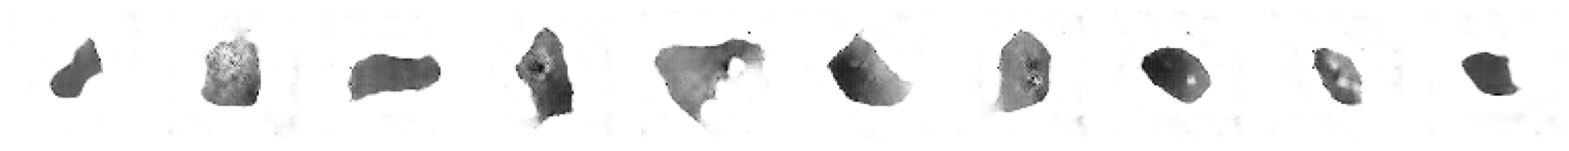

313/313 [==============================] - 80s 251ms/step - d_loss: 0.0052 - d_real_acc: 0.9158 - d_fake_acc: 0.9157 - d_acc: 0.9157 - g_loss: 5.5750 - g_acc: 0.0843
Epoch 17/50
313/313 [==============================] - ETA: 0s - d_loss: -0.0546 - d_real_acc: 0.9300 - d_fake_acc: 0.9314 - d_acc: 0.9307 - g_loss: 6.0586 - g_acc: 0.0686
Saved to ./output/generated_img_016.png


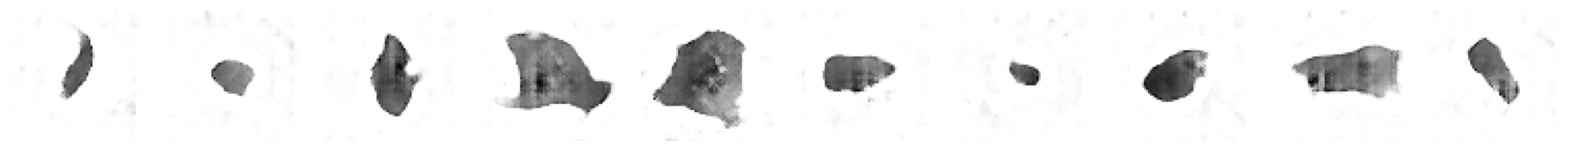

313/313 [==============================] - 80s 247ms/step - d_loss: -0.0546 - d_real_acc: 0.9300 - d_fake_acc: 0.9314 - d_acc: 0.9307 - g_loss: 6.0586 - g_acc: 0.0686
Epoch 18/50
313/313 [==============================] - ETA: 0s - d_loss: -0.0916 - d_real_acc: 0.9379 - d_fake_acc: 0.9410 - d_acc: 0.9395 - g_loss: 6.3663 - g_acc: 0.0590
Saved to ./output/generated_img_017.png


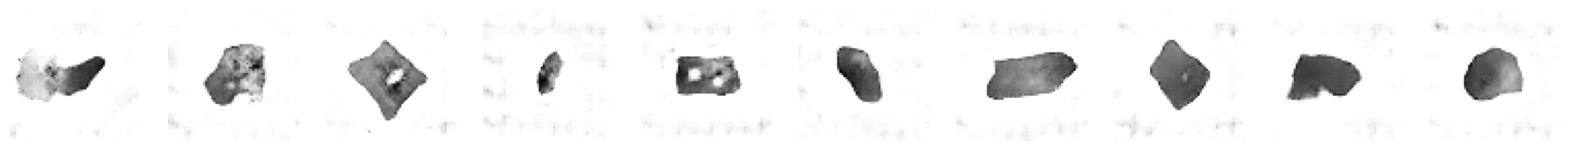

313/313 [==============================] - 80s 247ms/step - d_loss: -0.0916 - d_real_acc: 0.9379 - d_fake_acc: 0.9410 - d_acc: 0.9395 - g_loss: 6.3663 - g_acc: 0.0590
Epoch 19/50
313/313 [==============================] - ETA: 0s - d_loss: -0.0255 - d_real_acc: 0.9191 - d_fake_acc: 0.9212 - d_acc: 0.9202 - g_loss: 6.2270 - g_acc: 0.0787
Saved to ./output/generated_img_018.png


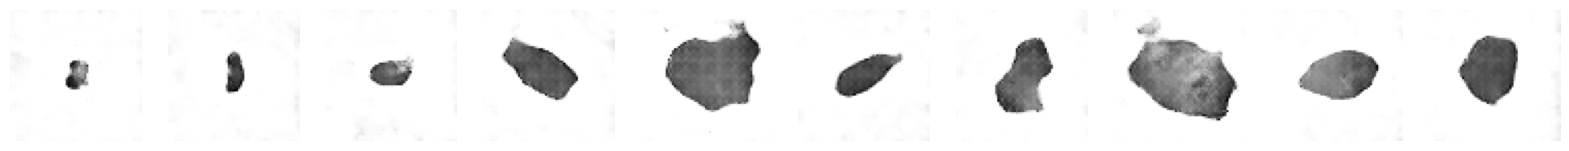

313/313 [==============================] - 80s 251ms/step - d_loss: -0.0255 - d_real_acc: 0.9191 - d_fake_acc: 0.9212 - d_acc: 0.9202 - g_loss: 6.2270 - g_acc: 0.0787
Epoch 20/50
313/313 [==============================] - ETA: 0s - d_loss: -0.0874 - d_real_acc: 0.9301 - d_fake_acc: 0.9310 - d_acc: 0.9305 - g_loss: 6.3727 - g_acc: 0.0690
Saved to ./output/generated_img_019.png


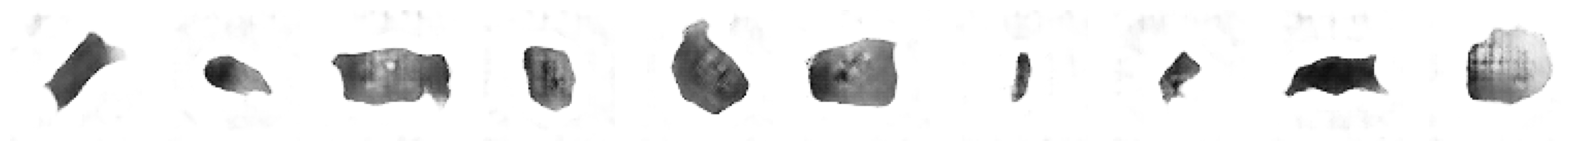

313/313 [==============================] - 80s 251ms/step - d_loss: -0.0874 - d_real_acc: 0.9301 - d_fake_acc: 0.9310 - d_acc: 0.9305 - g_loss: 6.3727 - g_acc: 0.0690
Epoch 21/50
313/313 [==============================] - ETA: 0s - d_loss: -0.1404 - d_real_acc: 0.9398 - d_fake_acc: 0.9424 - d_acc: 0.9411 - g_loss: 6.9470 - g_acc: 0.0576
Saved to ./output/generated_img_020.png


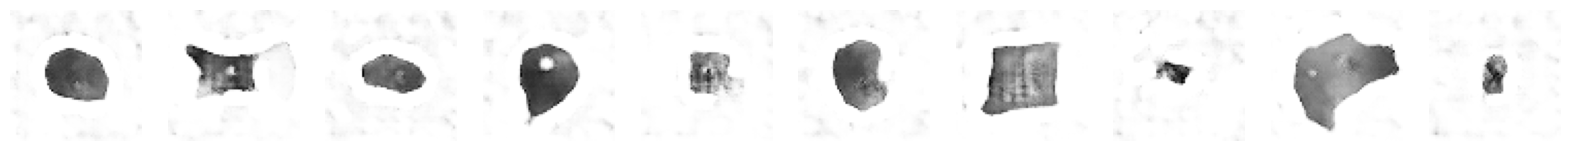

313/313 [==============================] - 81s 252ms/step - d_loss: -0.1404 - d_real_acc: 0.9398 - d_fake_acc: 0.9424 - d_acc: 0.9411 - g_loss: 6.9470 - g_acc: 0.0576
Epoch 22/50
313/313 [==============================] - ETA: 0s - d_loss: -0.0633 - d_real_acc: 0.9251 - d_fake_acc: 0.9250 - d_acc: 0.9250 - g_loss: 6.8604 - g_acc: 0.0750
Saved to ./output/generated_img_021.png


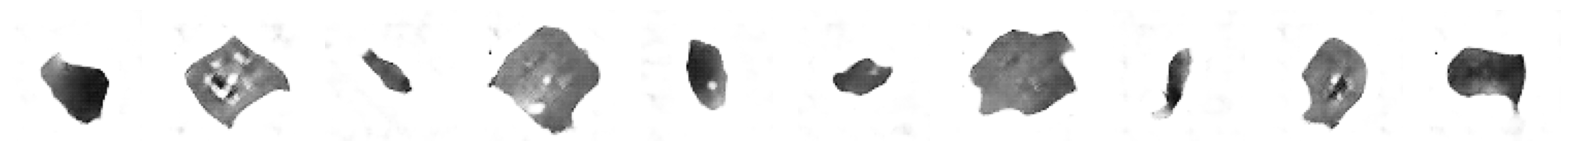

313/313 [==============================] - 80s 252ms/step - d_loss: -0.0633 - d_real_acc: 0.9251 - d_fake_acc: 0.9250 - d_acc: 0.9250 - g_loss: 6.8604 - g_acc: 0.0750
Epoch 23/50
313/313 [==============================] - ETA: 0s - d_loss: -0.0254 - d_real_acc: 0.9150 - d_fake_acc: 0.9151 - d_acc: 0.9150 - g_loss: 6.3932 - g_acc: 0.0849
Saved to ./output/generated_img_022.png


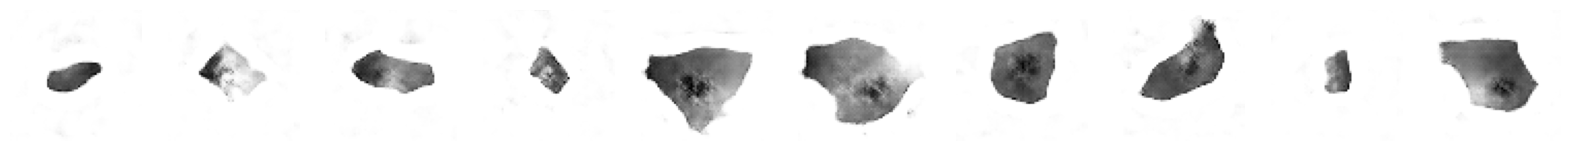

313/313 [==============================] - 81s 256ms/step - d_loss: -0.0254 - d_real_acc: 0.9150 - d_fake_acc: 0.9151 - d_acc: 0.9150 - g_loss: 6.3932 - g_acc: 0.0849
Epoch 24/50
313/313 [==============================] - ETA: 0s - d_loss: -0.0838 - d_real_acc: 0.9303 - d_fake_acc: 0.9312 - d_acc: 0.9307 - g_loss: 7.1390 - g_acc: 0.0689
Saved to ./output/generated_img_023.png


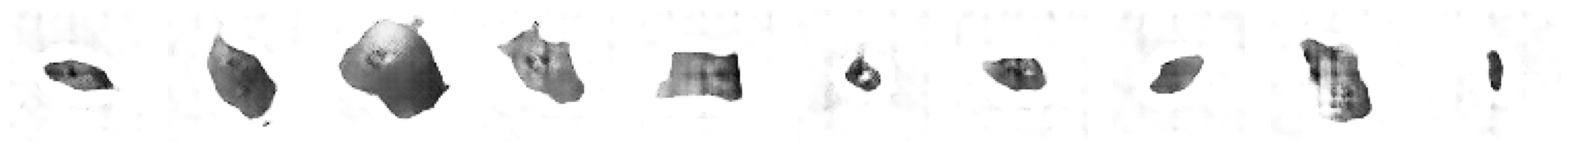

313/313 [==============================] - 81s 254ms/step - d_loss: -0.0838 - d_real_acc: 0.9303 - d_fake_acc: 0.9312 - d_acc: 0.9307 - g_loss: 7.1390 - g_acc: 0.0689
Epoch 25/50
313/313 [==============================] - ETA: 0s - d_loss: 0.3135 - d_real_acc: 0.8924 - d_fake_acc: 0.9435 - d_acc: 0.9179 - g_loss: 7.9328 - g_acc: 0.0565
Saved to ./output/generated_img_024.png


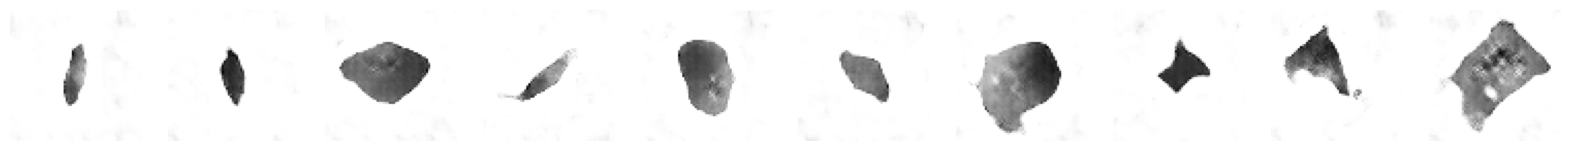

313/313 [==============================] - 84s 260ms/step - d_loss: 0.3135 - d_real_acc: 0.8924 - d_fake_acc: 0.9435 - d_acc: 0.9179 - g_loss: 7.9328 - g_acc: 0.0565
Epoch 26/50
313/313 [==============================] - ETA: 0s - d_loss: -0.1145 - d_real_acc: 0.9325 - d_fake_acc: 0.9327 - d_acc: 0.9326 - g_loss: 7.1777 - g_acc: 0.0674
Saved to ./output/generated_img_025.png


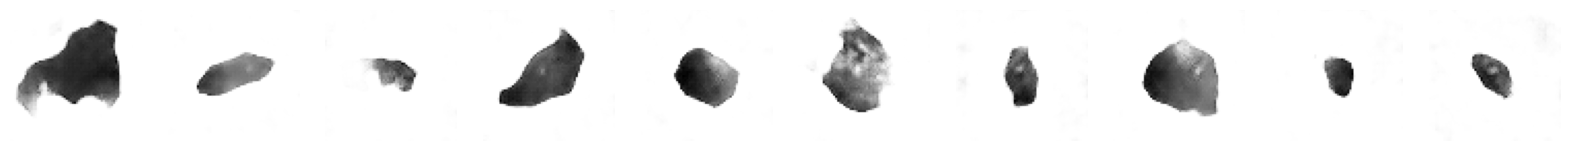

313/313 [==============================] - 82s 256ms/step - d_loss: -0.1145 - d_real_acc: 0.9325 - d_fake_acc: 0.9327 - d_acc: 0.9326 - g_loss: 7.1777 - g_acc: 0.0674
Epoch 27/50
313/313 [==============================] - ETA: 0s - d_loss: -0.0957 - d_real_acc: 0.9315 - d_fake_acc: 0.9332 - d_acc: 0.9323 - g_loss: 7.6871 - g_acc: 0.0668
Saved to ./output/generated_img_026.png


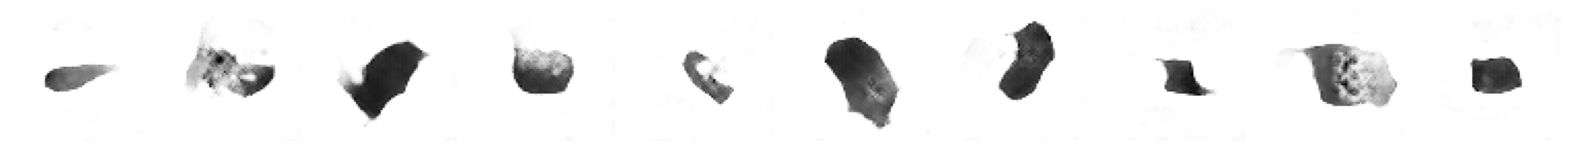

313/313 [==============================] - 83s 257ms/step - d_loss: -0.0957 - d_real_acc: 0.9315 - d_fake_acc: 0.9332 - d_acc: 0.9323 - g_loss: 7.6871 - g_acc: 0.0668
Epoch 28/50
313/313 [==============================] - ETA: 0s - d_loss: -0.1591 - d_real_acc: 0.9334 - d_fake_acc: 0.9324 - d_acc: 0.9329 - g_loss: 8.6073 - g_acc: 0.0676
Saved to ./output/generated_img_027.png


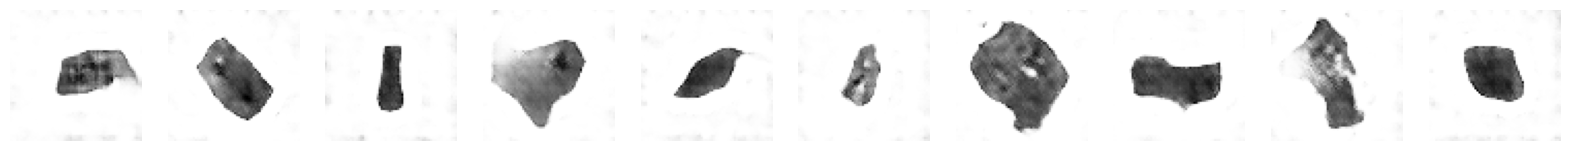

313/313 [==============================] - 82s 256ms/step - d_loss: -0.1591 - d_real_acc: 0.9334 - d_fake_acc: 0.9324 - d_acc: 0.9329 - g_loss: 8.6073 - g_acc: 0.0676
Epoch 29/50
313/313 [==============================] - ETA: 0s - d_loss: -0.1473 - d_real_acc: 0.9355 - d_fake_acc: 0.9373 - d_acc: 0.9364 - g_loss: 7.4430 - g_acc: 0.0627
Saved to ./output/generated_img_028.png


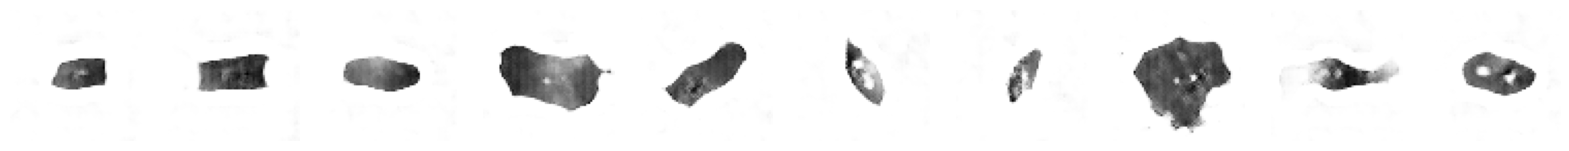

313/313 [==============================] - 82s 257ms/step - d_loss: -0.1473 - d_real_acc: 0.9355 - d_fake_acc: 0.9373 - d_acc: 0.9364 - g_loss: 7.4430 - g_acc: 0.0627
Epoch 30/50
313/313 [==============================] - ETA: 0s - d_loss: -0.0619 - d_real_acc: 0.9279 - d_fake_acc: 0.9269 - d_acc: 0.9274 - g_loss: 7.9186 - g_acc: 0.0732
Saved to ./output/generated_img_029.png


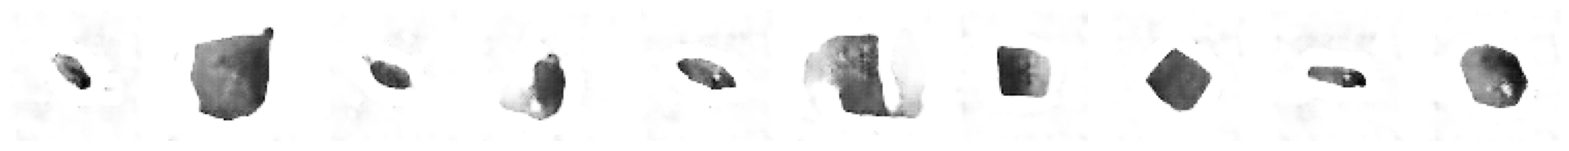

313/313 [==============================] - 87s 268ms/step - d_loss: -0.0619 - d_real_acc: 0.9279 - d_fake_acc: 0.9269 - d_acc: 0.9274 - g_loss: 7.9186 - g_acc: 0.0732
Epoch 31/50
313/313 [==============================] - ETA: 0s - d_loss: -0.1335 - d_real_acc: 0.9416 - d_fake_acc: 0.9452 - d_acc: 0.9434 - g_loss: 7.9295 - g_acc: 0.0547
Saved to ./output/generated_img_030.png


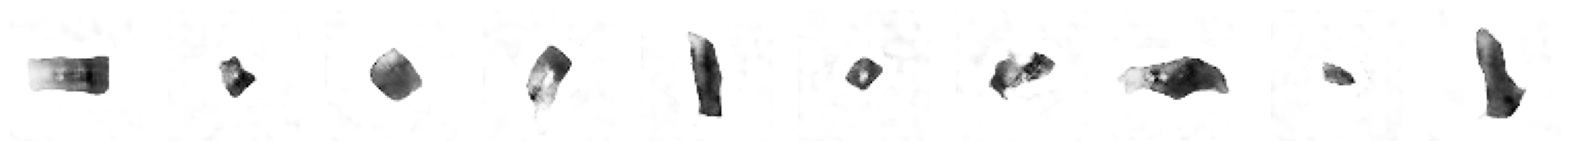

313/313 [==============================] - 82s 256ms/step - d_loss: -0.1335 - d_real_acc: 0.9416 - d_fake_acc: 0.9452 - d_acc: 0.9434 - g_loss: 7.9295 - g_acc: 0.0547
Epoch 32/50
313/313 [==============================] - ETA: 0s - d_loss: -0.1765 - d_real_acc: 0.9383 - d_fake_acc: 0.9398 - d_acc: 0.9390 - g_loss: 8.5346 - g_acc: 0.0602
Saved to ./output/generated_img_031.png


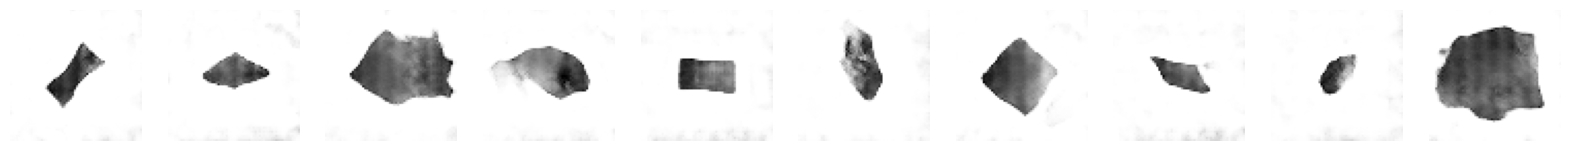

313/313 [==============================] - 84s 259ms/step - d_loss: -0.1765 - d_real_acc: 0.9383 - d_fake_acc: 0.9398 - d_acc: 0.9390 - g_loss: 8.5346 - g_acc: 0.0602
Epoch 33/50
313/313 [==============================] - ETA: 0s - d_loss: -0.3116 - d_real_acc: 0.9591 - d_fake_acc: 0.9609 - d_acc: 0.9600 - g_loss: 8.9286 - g_acc: 0.0391
Saved to ./output/generated_img_032.png


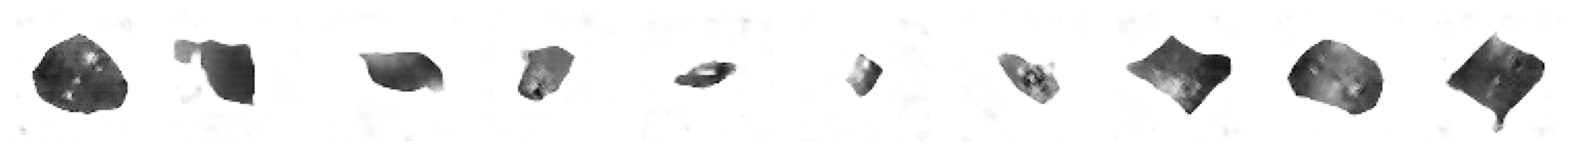

313/313 [==============================] - 82s 257ms/step - d_loss: -0.3116 - d_real_acc: 0.9591 - d_fake_acc: 0.9609 - d_acc: 0.9600 - g_loss: 8.9286 - g_acc: 0.0391
Epoch 34/50
313/313 [==============================] - ETA: 0s - d_loss: -0.0134 - d_real_acc: 0.9145 - d_fake_acc: 0.9178 - d_acc: 0.9161 - g_loss: 7.4856 - g_acc: 0.0822
Saved to ./output/generated_img_033.png


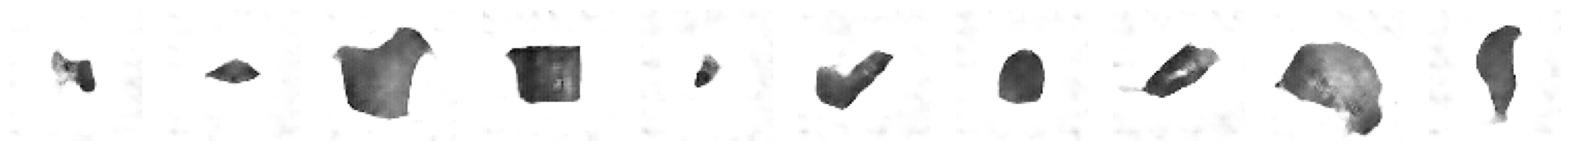

313/313 [==============================] - 83s 259ms/step - d_loss: -0.0134 - d_real_acc: 0.9145 - d_fake_acc: 0.9178 - d_acc: 0.9161 - g_loss: 7.4856 - g_acc: 0.0822
Epoch 35/50
313/313 [==============================] - ETA: 0s - d_loss: -0.2465 - d_real_acc: 0.9482 - d_fake_acc: 0.9444 - d_acc: 0.9463 - g_loss: 9.9133 - g_acc: 0.0556
Saved to ./output/generated_img_034.png


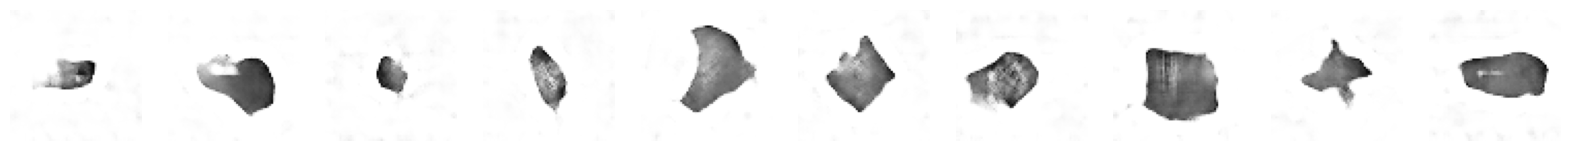

313/313 [==============================] - 82s 258ms/step - d_loss: -0.2465 - d_real_acc: 0.9482 - d_fake_acc: 0.9444 - d_acc: 0.9463 - g_loss: 9.9133 - g_acc: 0.0556
Epoch 36/50
313/313 [==============================] - ETA: 0s - d_loss: -0.2380 - d_real_acc: 0.9491 - d_fake_acc: 0.9519 - d_acc: 0.9505 - g_loss: 8.6487 - g_acc: 0.0481
Saved to ./output/generated_img_035.png


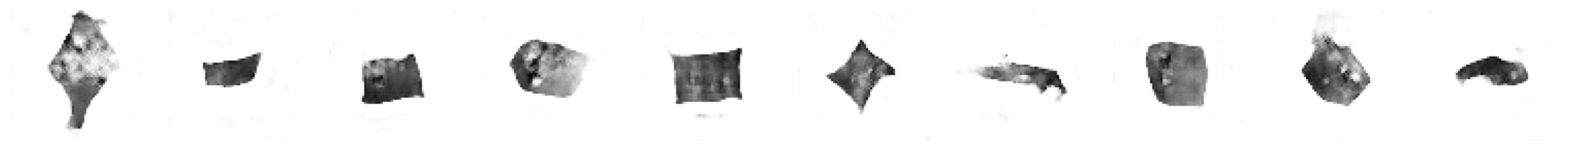

313/313 [==============================] - 83s 261ms/step - d_loss: -0.2380 - d_real_acc: 0.9491 - d_fake_acc: 0.9519 - d_acc: 0.9505 - g_loss: 8.6487 - g_acc: 0.0481
Epoch 37/50
313/313 [==============================] - ETA: 0s - d_loss: -0.2877 - d_real_acc: 0.9447 - d_fake_acc: 0.9571 - d_acc: 0.9509 - g_loss: 12.5111 - g_acc: 0.0429
Saved to ./output/generated_img_036.png


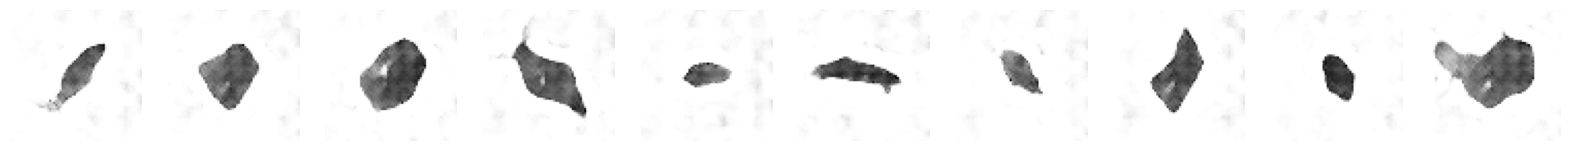

313/313 [==============================] - 86s 267ms/step - d_loss: -0.2877 - d_real_acc: 0.9447 - d_fake_acc: 0.9571 - d_acc: 0.9509 - g_loss: 12.5111 - g_acc: 0.0429
Epoch 38/50
313/313 [==============================] - ETA: 0s - d_loss: -0.2717 - d_real_acc: 0.9503 - d_fake_acc: 0.9538 - d_acc: 0.9521 - g_loss: 9.6756 - g_acc: 0.0462
Saved to ./output/generated_img_037.png


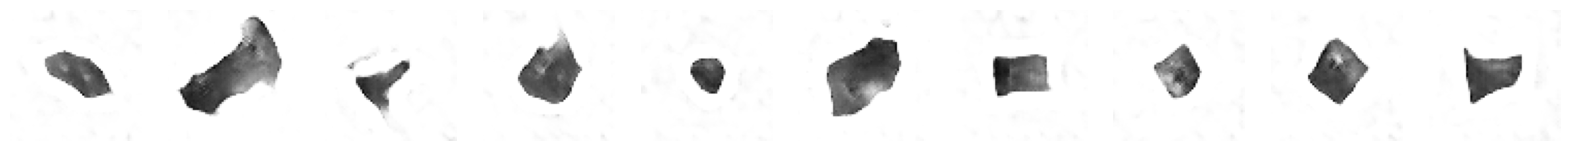

313/313 [==============================] - 83s 261ms/step - d_loss: -0.2717 - d_real_acc: 0.9503 - d_fake_acc: 0.9538 - d_acc: 0.9521 - g_loss: 9.6756 - g_acc: 0.0462
Epoch 39/50
313/313 [==============================] - ETA: 0s - d_loss: -0.7371 - d_real_acc: 0.9984 - d_fake_acc: 0.9981 - d_acc: 0.9983 - g_loss: 14.9935 - g_acc: 0.0019
Saved to ./output/generated_img_038.png


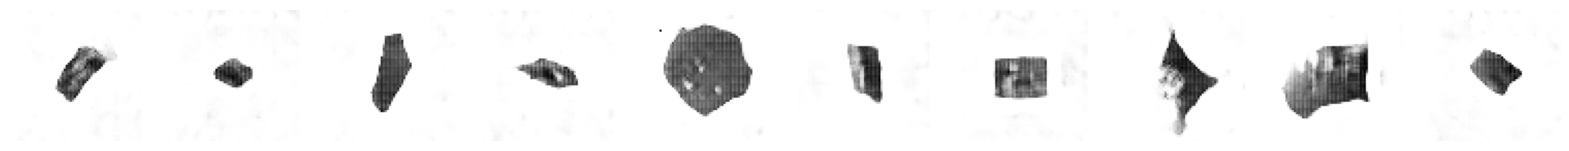

313/313 [==============================] - 84s 259ms/step - d_loss: -0.7371 - d_real_acc: 0.9984 - d_fake_acc: 0.9981 - d_acc: 0.9983 - g_loss: 14.9935 - g_acc: 0.0019
Epoch 40/50
313/313 [==============================] - ETA: 0s - d_loss: -0.3112 - d_real_acc: 0.9506 - d_fake_acc: 0.9509 - d_acc: 0.9508 - g_loss: 11.5794 - g_acc: 0.0491
Saved to ./output/generated_img_039.png


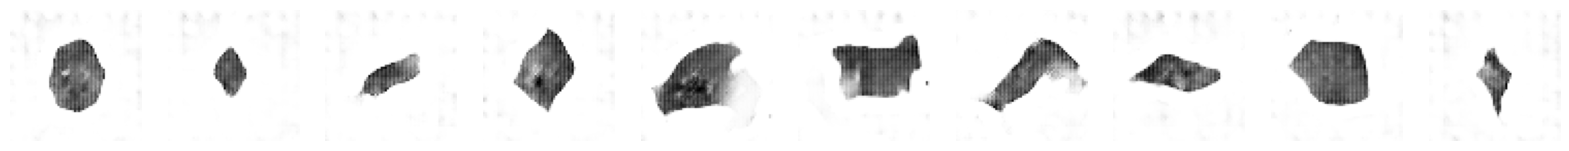

313/313 [==============================] - 84s 265ms/step - d_loss: -0.3112 - d_real_acc: 0.9506 - d_fake_acc: 0.9509 - d_acc: 0.9508 - g_loss: 11.5794 - g_acc: 0.0491
Epoch 41/50
313/313 [==============================] - ETA: 0s - d_loss: -0.7665 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4113 - g_acc: 0.0000e+00
Saved to ./output/generated_img_040.png


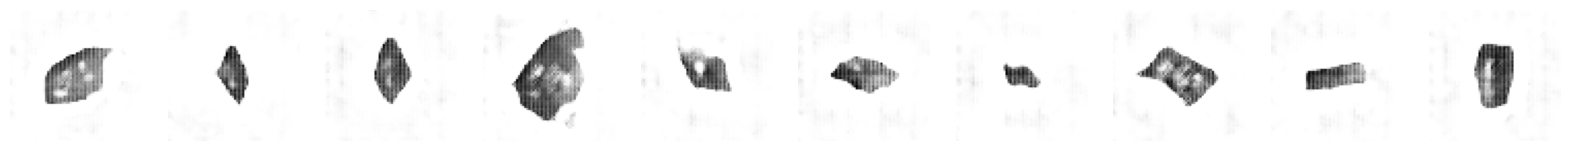

313/313 [==============================] - 83s 260ms/step - d_loss: -0.7665 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4113 - g_acc: 0.0000e+00
Epoch 42/50
313/313 [==============================] - ETA: 0s - d_loss: -0.7692 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Saved to ./output/generated_img_041.png


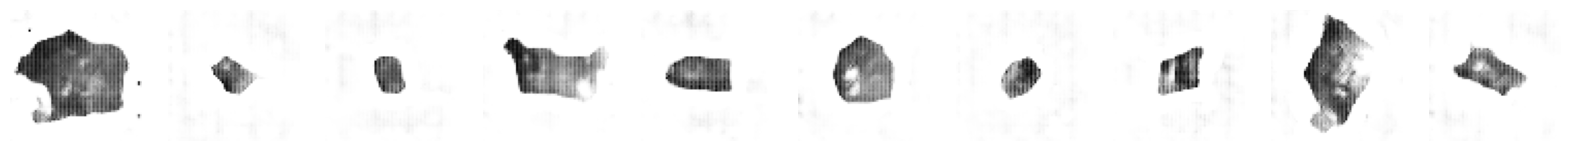

313/313 [==============================] - 83s 261ms/step - d_loss: -0.7692 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 43/50
313/313 [==============================] - ETA: 0s - d_loss: -0.7652 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Saved to ./output/generated_img_042.png


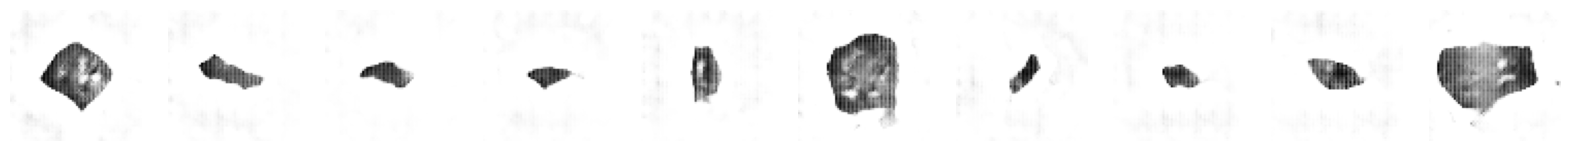

313/313 [==============================] - 87s 273ms/step - d_loss: -0.7652 - d_real_acc: 1.0000 - d_fake_acc: 1.0000 - d_acc: 1.0000 - g_loss: 15.4250 - g_acc: 0.0000e+00
Epoch 44/50
313/313 [==============================] - ETA: 0s - d_loss: -0.0550 - d_real_acc: 0.9143 - d_fake_acc: 0.9011 - d_acc: 0.9077 - g_loss: 11.7529 - g_acc: 0.0988
Saved to ./output/generated_img_043.png


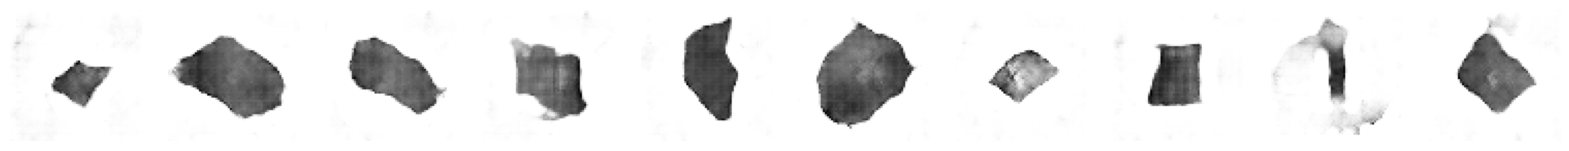

313/313 [==============================] - 86s 267ms/step - d_loss: -0.0550 - d_real_acc: 0.9143 - d_fake_acc: 0.9011 - d_acc: 0.9077 - g_loss: 11.7529 - g_acc: 0.0988
Epoch 45/50
313/313 [==============================] - ETA: 0s - d_loss: -0.2645 - d_real_acc: 0.9556 - d_fake_acc: 0.9598 - d_acc: 0.9577 - g_loss: 9.3993 - g_acc: 0.0402
Saved to ./output/generated_img_044.png


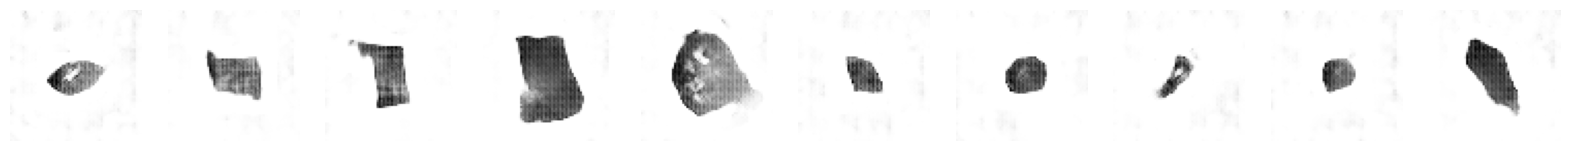

313/313 [==============================] - 84s 265ms/step - d_loss: -0.2645 - d_real_acc: 0.9556 - d_fake_acc: 0.9598 - d_acc: 0.9577 - g_loss: 9.3993 - g_acc: 0.0402
Epoch 46/50
313/313 [==============================] - ETA: 0s - d_loss: -0.3015 - d_real_acc: 0.9512 - d_fake_acc: 0.9487 - d_acc: 0.9499 - g_loss: 11.7223 - g_acc: 0.0513
Saved to ./output/generated_img_045.png


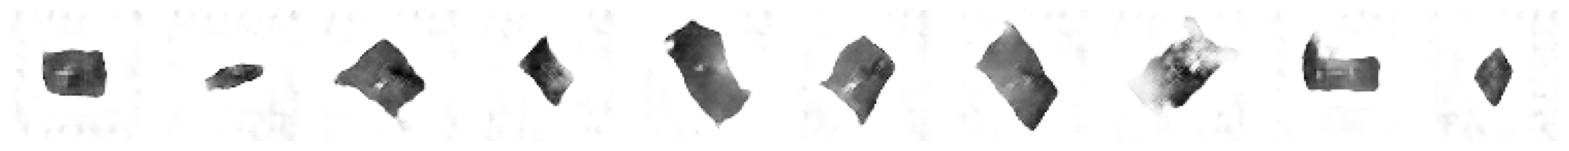

313/313 [==============================] - 85s 266ms/step - d_loss: -0.3015 - d_real_acc: 0.9512 - d_fake_acc: 0.9487 - d_acc: 0.9499 - g_loss: 11.7223 - g_acc: 0.0513
Epoch 47/50
313/313 [==============================] - ETA: 0s - d_loss: -0.3089 - d_real_acc: 0.9618 - d_fake_acc: 0.9636 - d_acc: 0.9628 - g_loss: 9.0411 - g_acc: 0.0364
Saved to ./output/generated_img_046.png


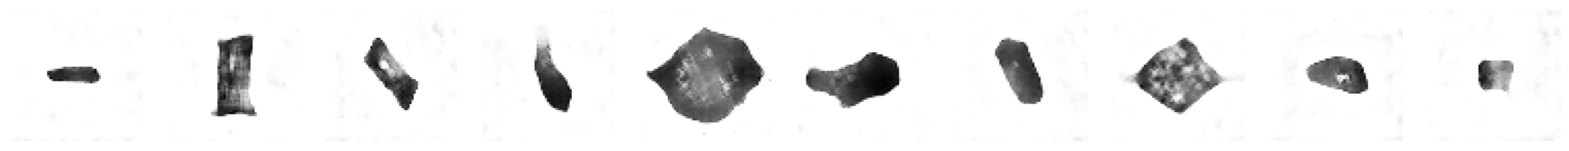

313/313 [==============================] - 85s 267ms/step - d_loss: -0.3089 - d_real_acc: 0.9618 - d_fake_acc: 0.9636 - d_acc: 0.9628 - g_loss: 9.0411 - g_acc: 0.0364
Epoch 48/50
313/313 [==============================] - ETA: 0s - d_loss: -0.2658 - d_real_acc: 0.9474 - d_fake_acc: 0.9465 - d_acc: 0.9470 - g_loss: 9.4318 - g_acc: 0.0535
Saved to ./output/generated_img_047.png


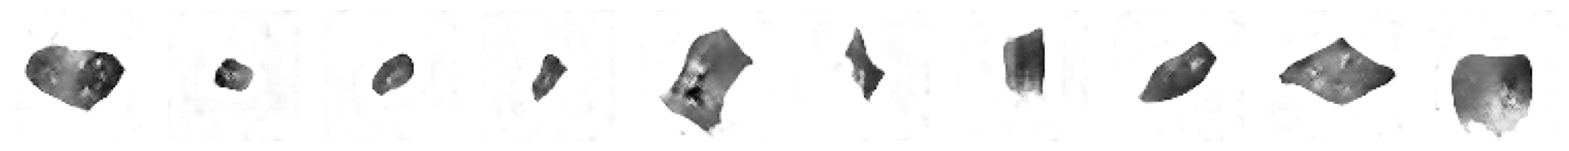

313/313 [==============================] - 87s 270ms/step - d_loss: -0.2658 - d_real_acc: 0.9474 - d_fake_acc: 0.9465 - d_acc: 0.9470 - g_loss: 9.4318 - g_acc: 0.0535
Epoch 49/50
313/313 [==============================] - ETA: 0s - d_loss: -0.4296 - d_real_acc: 0.9674 - d_fake_acc: 0.9689 - d_acc: 0.9682 - g_loss: 11.0105 - g_acc: 0.0311
Saved to ./output/generated_img_048.png


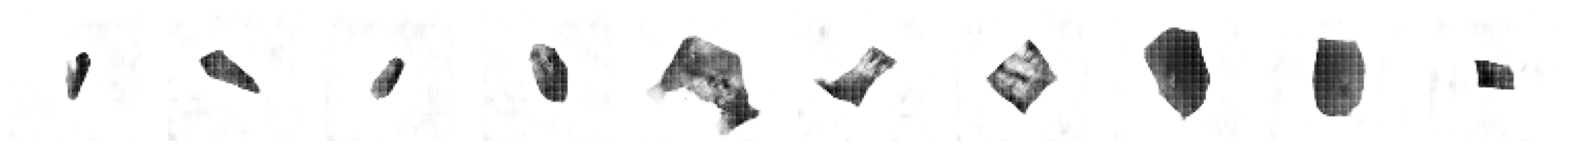

313/313 [==============================] - 85s 268ms/step - d_loss: -0.4296 - d_real_acc: 0.9674 - d_fake_acc: 0.9689 - d_acc: 0.9682 - g_loss: 11.0105 - g_acc: 0.0311
Epoch 50/50
313/313 [==============================] - ETA: 0s - d_loss: -0.5301 - d_real_acc: 0.9733 - d_fake_acc: 0.9741 - d_acc: 0.9737 - g_loss: 13.1809 - g_acc: 0.0259
Saved to ./output/generated_img_049.png


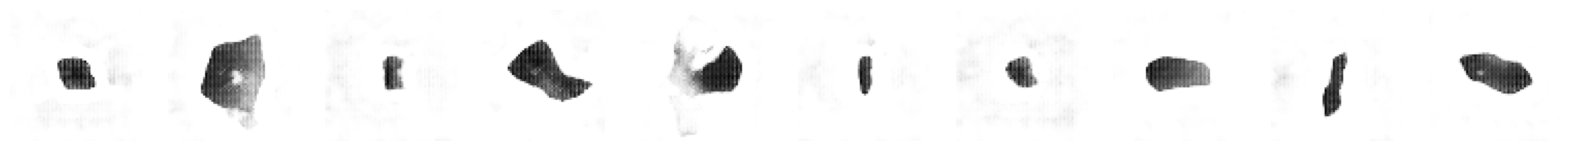

313/313 [==============================] - 85s 267ms/step - d_loss: -0.5301 - d_real_acc: 0.9733 - d_fake_acc: 0.9741 - d_acc: 0.9737 - g_loss: 13.1809 - g_acc: 0.0259


In [25]:
dcgan.fit(
    train,
    epochs=50,
    callbacks=[
        model_checkpoint_callback,
        tensorboard_callback,
        ImageGenerator(num_img=10, latent_dim=100),
    ],
)

## Generating new images

In [29]:
grid_width, grid_height = (10,3)
z_sample= np.random.normal(size=(grid_height* grid_width, 100))

In [30]:
reconstructions = generator.predict(z_sample)

1/1 [==============================] - 1s 642ms/step


In [32]:
import matplotlib.pyplot as plt

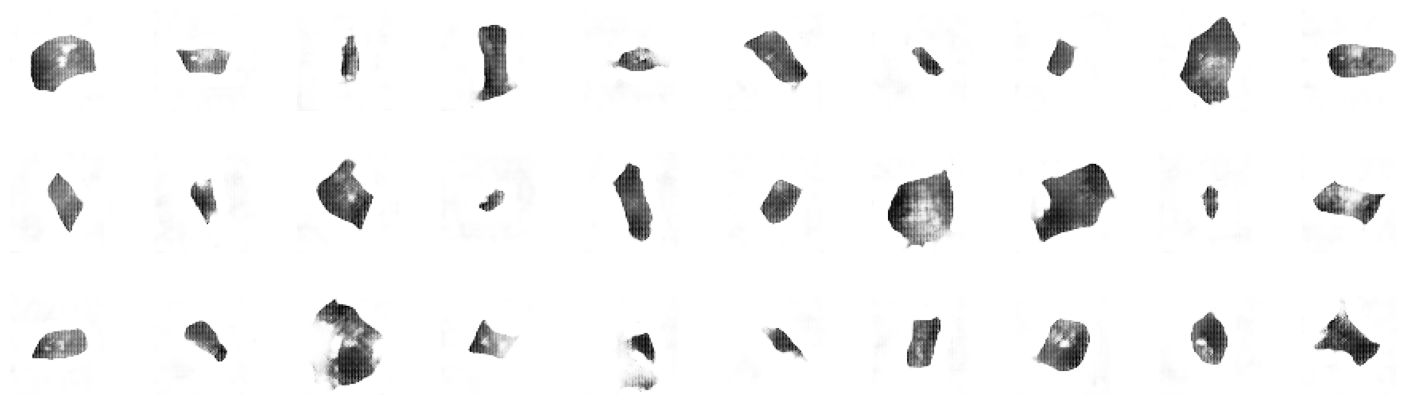

In [33]:
fig = plt.figure(figsize=(18, 5))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_width * grid_height):
    ax = fig.add_subplot(grid_height, grid_width, i + 1)
    ax.axis("off")
    ax.imshow(reconstructions[i, :, :], cmap="Greys")

In [34]:
def compare_images(img1, img2):
    return np.mean(np.abs(img1 - img2))

In [35]:
all_data = []
for i in train.as_numpy_iterator():
    all_data.extend(i)
all_data = np.array(all_data)

In [36]:
all_data.shape

(40000, 64, 64, 1)

1/1 [==============================] - 0s 464ms/step


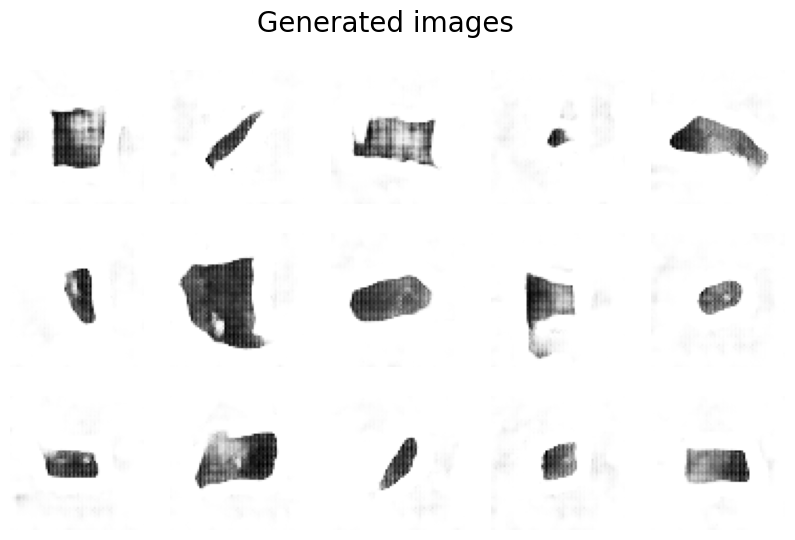

In [37]:
r, c = 3, 5
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Generated images", fontsize=20)

noise = np.random.normal(size=(r * c, 100))
gen_imgs = generator.predict(noise)

cnt = 0
for i in range(r):
    for j in range(c):
        axs[i, j].imshow(gen_imgs[cnt], cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()

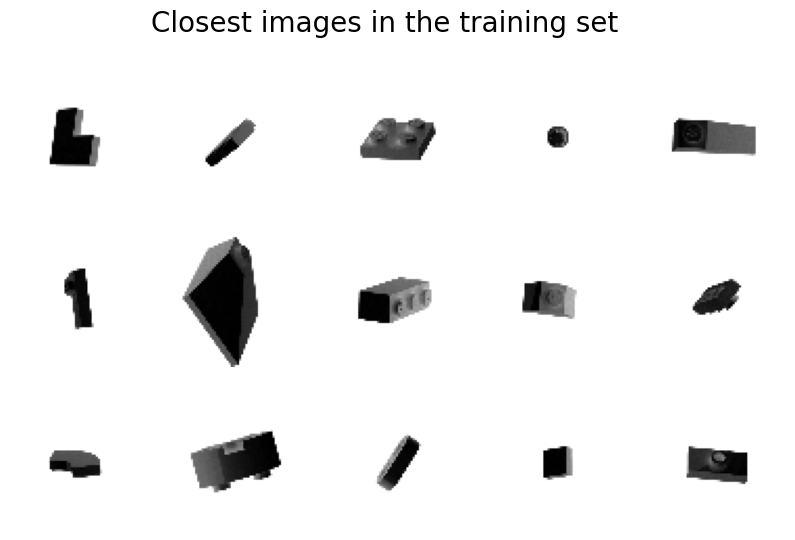

In [46]:
fig, axs = plt.subplots(r, c, figsize=(10, 6))
fig.suptitle("Closest images in the training set", fontsize=20)

cnt = 0
for i in range(r):
    for j in range(c):
        c_diff = 99999
        c_img = None
        for k_idx, k in enumerate(all_data):
            diff = compare_images(gen_imgs[cnt], k)
            if diff < c_diff:
                c_img = np.copy(k)
                c_diff = diff
        axs[i, j].imshow(c_img, cmap="gray_r")
        axs[i, j].axis("off")
        cnt += 1

plt.show()